# Obtaining the growth data from the Forest Vegetation Simulator that will serve as reference for the calibration

The [Forest Vegetation Simulator](https://www.fs.usda.gov/fvs/) (FVS) model was develloped by the US department of Agriculture and Forestry (USDA). It aims to predict the growth and yield of forest stands based on internal equations derived for empirical data, but it also have options to be calibrated or adjusted based on the input data.

Eric Gustafson recommands its use for the first step of the calibration procedure of PnET Succession (see [Gustafson and Miranda (2023)](./ReferencesAndData/Gustafson2024PnETUserGuide.pdf)), where we try to make sure that the growth curve of a new cohort matches what is seen in reality. This is because the curves produced by FVS can be easily compared to PnET, without the trouble that often comes when using real empirical data for such a procedure (as empirical data is messy, needs to be cleaned, has outliers, etc.). As such, using FVS to calibrate PnET is called by some "meta-modelling" - as empirical data has been used to create the FVS model, which is then used to calibrate PnET.

The FVS model is already compiled inside of the Docker image used to produced this document (see the [readme file](https://github.com/Klemet/Calibration_PnET_DIVERSE/blob/main/README.md) to deploy it easily on your computer), thanks to the code provided in [this issue](https://github.com/USDAForestService/ForestVegetationSimulator/issues/44#issuecomment-2483578729). What that means is that FVS can be run from Python functions that I created here (see [functionsForCalibration.py](./functionsForCalibration.py)) without any need for manually creating the intputs for a FVS simulation (or projection, as it is more usually called in the user guides); or to manually analyze the outputs of FVS.

## Custom python function used to obtain growth data from FVS for a monoculture

The function `FVS_on_simulationOnSingleEmptyStand` (inside [functionsForCalibration.py](./functionsForCalibration.py)) will be main one that we will be using to calibrate PnET.

This function does the following :

- It creates a MySQL database containg the stand and trees inputs necessary for a simple FVS simulation that contains only young trees of a single species (monoculture) in ideal or default conditions at the beginning.
    - These initial conditions are used to replicate what happens when we initialize a new age cohort on an empty cell in PnET, in order to do the calibration on monoculture and ideal conditions.
    - While the function allows the user to specify the number of trees, I will use 2471 trees (which will initialize a 1ha stand with 2471 trees) which is the value used in [Reese et al. 2024, supp. mat. A](https://cdnsciencepub.com/doi/10.1139/cjfr-2024-0085) (recommanded by [Brian Sturtevant](https://research.fs.usda.gov/about/people/sturtevant)).
    - The function also allows the user to specify the "Site index" for the stand, which is a value representing the quality of the soil for the species (and is thus used to increase tree growth in the equations inside FVS). [Reese et al. 2024, supp. mat. A](https://cdnsciencepub.com/doi/10.1139/cjfr-2024-0085) tend to use high site index as the reference to calibrate PnET, which matches the advice of [Gustafson and Miranda (2023)](./ReferencesAndData/Gustafson2024PnETUserGuide.pdf) (who recommands that this first calibration step should be done on "ideal conditions"). As the Site Index is a value that varies from species to species, I recommand [this report from the USDA](https://www.fs.usda.gov/nrs/pubs/gtr/gtr_nc128.pdf) that shows ranges of values of Site Index in the USA for many species. I will also make several FVS simulations with lower site index values for comparison.
- I creates a simple keyword file, which is the file that defines what stands are simulated, and how.
    - The keyword file generated simply simulate one stand with a single tree age cohort, and output carbon estimates in the main output file (which are then used to derive aboveground biomass estimates we can compare to PnET)
- It runs the simulation by calling the right FVS "variant" as indicated by the user
    - There exists more than a dozen FVS variants for different regions of the united states, but also one for Ontario and one for British Columbia. I'll be using the Ontario variante here by default.
- It reads the outputs to return a dictionnary of values that associates a year (e.g. 2033) to an aboveground biomass value. Convertion from carbon to biomass is explained in the code of the function.
- The files generated for (inputs) and by (outputs) the FVS simulation are deleted by default (`clearFiles` argument), but this can be overriden.

## Example

In [1]:
# We import the functions
from functionsForCalibration import *

# We run FVS three times to simulate a basalm fir monoculture on an initially empty stand, and specify all of the arguments

basalmFir_LowSiteIndex = FVS_on_simulationOnSingleEmptyStand(Latitude = 47.22029, # Atikamekw village of Manawan, center of one of our study areas
                                    Longitude = -74.38606, # Atikamekw village of Manawan, center of one of our study areas
                                    Slope = 0, # We want ideal/neutral conditions, so no slope
                                    Elevation = 0, # We want ideal/neutral conditions, so no elevation 
                                    treeSpeciesCode = "BF", # Balsam fir. All codes are available at https://github.com/USDAForestService/ForestVegetationSimulator/blob/5c29887e4168fd8182c1b2bad762f900b7d7e90c/canada/on/grinit.f#L43
                                    treesPerHectares = 2471, # To replicate stocking density from  https://cdnsciencepub.com/doi/10.1139/cjfr-2024-0085, supp. mat. A
                                    siteIndex = 20, # Low site index for Balsam fir. See https://www.fs.usda.gov/nrs/pubs/gtr/gtr_nc128.pdf
                                    variant = "FVSon",
                                    folderForFiles = "/calibrationFolder/FVS_SingleEmptyStandRun",
                                    clearFiles = True)

basalmFir_averageSiteIndex = FVS_on_simulationOnSingleEmptyStand(Latitude = 47.22029, # Atikamekw village of Manawan, center of one of our study areas
                                    Longitude = -74.38606, # Atikamekw village of Manawan, center of one of our study areas
                                    Slope = 0, # We want ideal/neutral conditions, so no slope
                                    Elevation = 0, # We want ideal/neutral conditions, so no elevation 
                                    treeSpeciesCode = "BF", # Balsam fir. All codes are available at https://github.com/USDAForestService/ForestVegetationSimulator/blob/5c29887e4168fd8182c1b2bad762f900b7d7e90c/canada/on/grinit.f#L43
                                    treesPerHectares = 2471, # To replicate stocking density from  https://cdnsciencepub.com/doi/10.1139/cjfr-2024-0085, supp. mat. A
                                    siteIndex = 45, # Average site index for Balsam fir. See https://www.fs.usda.gov/nrs/pubs/gtr/gtr_nc128.pdf
                                    variant = "FVSon",
                                    folderForFiles = "/calibrationFolder/FVS_SingleEmptyStandRun",
                                    clearFiles = True)

basalmFir_HighSiteIndex = FVS_on_simulationOnSingleEmptyStand(Latitude = 47.22029, # Atikamekw village of Manawan, center of one of our study areas
                                    Longitude = -74.38606, # Atikamekw village of Manawan, center of one of our study areas
                                    Slope = 0, # We want ideal/neutral conditions, so no slope
                                    Elevation = 0, # We want ideal/neutral conditions, so no elevation 
                                    treeSpeciesCode = "BF", # Balsam fir. All codes are available at https://github.com/USDAForestService/ForestVegetationSimulator/blob/5c29887e4168fd8182c1b2bad762f900b7d7e90c/canada/on/grinit.f#L43
                                    treesPerHectares = 2471, # To replicate stocking density from  https://cdnsciencepub.com/doi/10.1139/cjfr-2024-0085, supp. mat. A
                                    siteIndex = 70, # High site index for Balsam fir. See https://www.fs.usda.gov/nrs/pubs/gtr/gtr_nc128.pdf
                                    variant = "FVSon",
                                    folderForFiles = "/calibrationFolder/FVS_SingleEmptyStandRun",
                                    clearFiles = True)

The directory '/calibrationFolder/FVS_SingleEmptyStandRun' has been deleted.
The directory '/calibrationFolder/FVS_SingleEmptyStandRun' has been created.
Creating Database with stand and tree ini values
Creating Keyword file
Launching FVS sim


Clearing files
The directory '/calibrationFolder/FVS_SingleEmptyStandRun' has been deleted.
The directory '/calibrationFolder/FVS_SingleEmptyStandRun' has been created.
Creating Database with stand and tree ini values
Creating Keyword file
Launching FVS sim


Clearing files
The directory '/calibrationFolder/FVS_SingleEmptyStandRun' has been deleted.
The directory '/calibrationFolder/FVS_SingleEmptyStandRun' has been created.
Creating Database with stand and tree ini values
Creating Keyword file
Launching FVS sim
Clearing files


The directory '/calibrationFolder/FVS_SingleEmptyStandRun' has been deleted.


In [2]:
# We print the outputs of one of the simulations
print(basalmFir_HighSiteIndex)

{2023: 0.4, 2033: 2.6, 2043: 21.6, 2053: 61.0, 2063: 86.4, 2073: 113.6, 2083: 134.4, 2093: 155.6, 2103: 175.8, 2113: 196.6, 2123: 216.8, 2133: 239.6}


```{admonition} Other uses of FVS
:class: tip
FVS can also output belowground biomass (both live and dead) using the CARBPRET (carbon report) keyword.
This can be useful to paramterize several parameters of PnET Succession related to the biomass of roots.
```

```{admonition} Learning more about FVS
:class: note
FVS is a complex model with more than a decade of improvments. The existing Python functions present here should be enough to calibrate PnET Succession; but if you need more information about variants, possible outputs and inputs, you can take a look at the many [user guides](https://www.fs.usda.gov/fvs/documents/guides.shtml) that are available online.
```



## Test : Comparing FVS outputs to PnET outputs

Using the same functions to read and run a simple PnET scenario as used in [Making a test simulation to get used to the functions](./2.Test_sim_functions.ipynb).

In [3]:
# Loading parameters and launching a simple PnET sim
from functionsForCalibration import *
# Loading parameters from template
PnETGitHub_OneCellSim = parse_All_LANDIS_PnET_Files(r"./SimulationFiles/PnETGitHub_OneCellSim")
# Editing initial communities to only have single cohort of Pinus banksiana
del PnETGitHub_OneCellSim["initial-communities.txt"]["querrubr"]
PnETGitHub_OneCellSim["initial-communities.txt"]["pinubank"] = '1'
# print(PnETGitHub_OneCellSim["initial-communities.txt"])
# Editing cell length so that one cell = 1ha
PnETGitHub_OneCellSim["scenario.txt"]["CellLength"] = 100
# Putting duration to 120 years
PnETGitHub_OneCellSim["scenario.txt"]["Duration"] = 120

Found : Additional file : !Run_scenario.bat
Found : PnET OutputBiomass parameter file : biomass.outputPnET.txt
Found : Climate file : climate.txt
Found : Disturbance Reduction File : disturbance_reductions.txt
Found : Additional file : ecoregion.img
Found : Main ecoregions file : ecoregion.txt
Found : PnET Ecoregion parameter file : EcoregionParameters.txt
Found : Additional file : initial-communities.img
Found : Initial Communities file : initial-communities.txt
Found : PnET generic parameter file : PnETGenericParameters.txt
Found : PnET OutputSites parameter file : PnEToutputsites_onecell.txt
Found : Main PnET parameter file : pnetsuccession.txt
Found : Additional file : README.txt
Found : Main scenario file : scenario.txt
Found : Main species parameter file : species.txt
Found : PnET species parameters file : SpeciesParameters.txt


In [4]:
# Writing parameters in temporary folder
testScenarioPath = "/tmp/TestScenarioPnET/"
if not os.path.exists(testScenarioPath):
    os.mkdir(testScenarioPath)
else:
    shutil.rmtree(testScenarioPath)
    os.mkdir(testScenarioPath)

write_all_LANDIS_files(testScenarioPath,
                       PnETGitHub_OneCellSim,
                       True)
# Running LANDIS-II sim
runLANDIS_Simulation("/tmp/TestScenarioPnET/",
                     "scenario.txt",
                    False,
                    5)
# Parsing outputs
result_sitesCSV = parse_CSVFiles_PnET_SitesOutput("/tmp/TestScenarioPnET/Output/Site1",
                                                  int(PnETGitHub_OneCellSim["pnetsuccession.txt"]["StartYear"]))

Found : Additional file : !Run_scenario.bat
Found : PnET OutputBiomass parameter file : biomass.outputPnET.txt
Found : Climate file : climate.txt
Found : Disturbance Reduction File : disturbance_reductions.txt
Found : Additional file : ecoregion.img
Found : Main ecoregions file : ecoregion.txt
Found : PnET Ecoregion parameter file : EcoregionParameters.txt
Found : Additional file : initial-communities.img
Found : Initial Communities file : initial-communities.txt
Found : PnET generic parameter file : PnETGenericParameters.txt
Found : PnET OutputSites parameter file : PnEToutputsites_onecell.txt
Found : Main PnET parameter file : pnetsuccession.txt
Found : Additional file : README.txt
Found : Main scenario file : scenario.txt
Found : Main species parameter file : species.txt
Found : PnET species parameters file : SpeciesParameters.txt
Launching LANDIS-II simulation with command : /bin/bash -c "cd /tmp/TestScenarioPnET/ && dotnet $LANDIS_CONSOLE scenario.txt"


Timeout occurred while waiting for LANDIS-II output.


In [5]:
# Running FVS simulation with pinus banksiana
jackPine_HighSiteIndex = FVS_on_simulationOnSingleEmptyStand(Latitude = 42.73361, # Capital of michigan, to approximate where the parameters of this PnET sample scenario were made
                                    Longitude = -84.55556, # Capital of michigan, to approximate where the parameters of this PnET sample scenario were made
                                    Slope = 0, # We want ideal/neutral conditions, so no slope
                                    Elevation = 0, # We want ideal/neutral conditions, so no elevation 
                                    treeSpeciesCode = "PJ", # Jack Pine, pinus banksiana. All codes are available at https://github.com/USDAForestService/ForestVegetationSimulator/blob/5c29887e4168fd8182c1b2bad762f900b7d7e90c/canada/on/grinit.f#L43
                                    treesPerHectares = 2471, # To replicate stocking density from  https://cdnsciencepub.com/doi/10.1139/cjfr-2024-0085, supp. mat. A
                                    siteIndex = 70, # High site index for the Jack Pine. See https://www.fs.usda.gov/nrs/pubs/gtr/gtr_nc128.pdf
                                    variant = "FVSon",
                                    timestep = 3,
                                    numberOfTimesteps = 40,
                                    folderForFiles = "/calibrationFolder/FVS_SingleEmptyStandRun",
                                    clearFiles = False)

print(jackPine_HighSiteIndex)

The directory '/calibrationFolder/FVS_SingleEmptyStandRun' has been created.
Creating Database with stand and tree ini values
Creating Keyword file
Launching FVS sim


{2023: 0.4, 2026: 1.8, 2029: 6.0, 2032: 12.6, 2035: 21.8, 2038: 33.4, 2041: 47.8, 2044: 64.8, 2047: 81.4, 2050: 93.4, 2053: 106.4, 2056: 111.8, 2059: 114.4, 2062: 116.8, 2065: 119.0, 2068: 121.4, 2071: 123.4, 2074: 125.6, 2077: 127.8, 2080: 129.8, 2083: 131.6, 2086: 134.2, 2089: 135.0, 2092: 132.4, 2095: 130.2, 2098: 128.4, 2101: 126.4, 2104: 124.4, 2107: 122.4, 2110: 120.6, 2113: 119.0, 2116: 117.4, 2119: 115.6, 2122: 114.0, 2125: 112.6, 2128: 111.0, 2131: 109.6, 2134: 108.4, 2137: 107.0, 2140: 105.8}


All plots have been generated and saved.


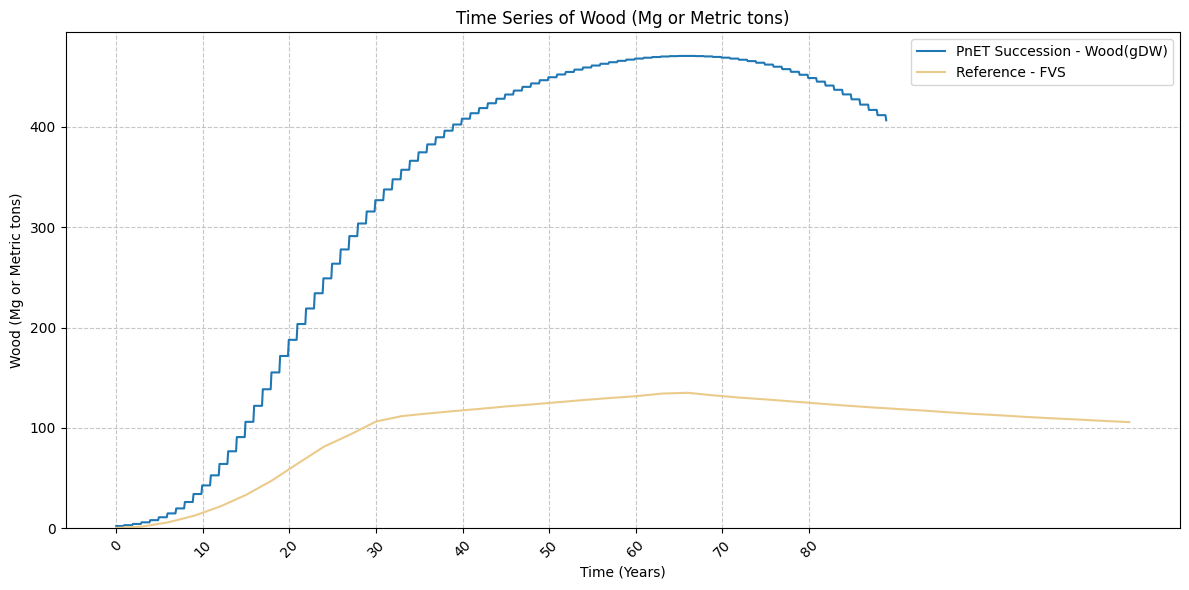

In [6]:
# Ploting the outputs from PnET and FVS together
# We re-format the time entries of the FVS dictionnary so that years are expressed in absoluted (from 0 to 120)
initialKeys = list(jackPine_HighSiteIndex.keys())
# print(initialKeys)
if initialKeys[0] != 0:
    for key in initialKeys:
        jackPine_HighSiteIndex[key - 2023] = jackPine_HighSiteIndex[key]
        del jackPine_HighSiteIndex[key]

plot_TimeSeries_CSV_PnETSitesOutputs(list(result_sitesCSV.values())[0],
                                     referenceDict = {"Wood(gDW)":{"Time":list(jackPine_HighSiteIndex.keys()), "Values":list(jackPine_HighSiteIndex.values())}},
                                     columnToPlotSelector = ["Wood(gDW)"],
                                     trueTime = False,
                                     realBiomass = True,
                                     cellLength = int(PnETGitHub_OneCellSim["scenario.txt"]["CellLength"]))

Here, we can see a pretty large divergence between the prediction of PnET succession and the projection of FVS. The parameters used in PnET Succession are derived from a template on Github, and are of unknown origin to me. Let's try again, but with the initial parameters that I have identified.

## Another test - with more robut parameters

The parameters that we will use this time come from [Initial species parameters](./3.Initial_Species_Parameters.ipynb).

In [7]:
# Loading parameters and launching a simple PnET sim
from functionsForCalibration import *
import json

# Loading parameters from template
PnETGitHub_OneCellSim = parse_All_LANDIS_PnET_Files(r"./SimulationFiles/PnETGitHub_OneCellSim")
# Editing initial communities to only have single cohort of Abies Balsamea
del PnETGitHub_OneCellSim["initial-communities.txt"]["querrubr"]
del PnETGitHub_OneCellSim["initial-communities.txt"]["pinubank"]
PnETGitHub_OneCellSim["initial-communities.txt"]["abiebals"] = '1'

# Editing cell length so that one cell = 1ha
PnETGitHub_OneCellSim["scenario.txt"]["CellLength"] = 100
# Putting duration to 120 years
PnETGitHub_OneCellSim["scenario.txt"]["Duration"] = 240

# We load the initial parameters (see 3.Initial_Species_Parameters.ipynb)
with open('./SpeciesParametersSets/Initial/initialCoreSpeciesParameters.json', 'r') as json_file:
    coreSpeciesParameters = json.load(json_file)
with open('./SpeciesParametersSets/Initial/initialPnETSpeciesParameters.json', 'r') as json_file:
    PnETSpeciesParametersFinal = json.load(json_file)
with open('./SpeciesParametersSets/Initial/InitialGenericParameters.json', 'r') as json_file:
    genericParameters = json.load(json_file)

# We replace the dictionnaries from the template with the ones with the initial parameters
PnETGitHub_OneCellSim["species.txt"] = coreSpeciesParameters
PnETGitHub_OneCellSim["SpeciesParameters.txt"] = PnETSpeciesParametersFinal
PnETGitHub_OneCellSim["PnETGenericParameters.txt"] = genericParameters

# Writing parameters in temporary folder
testScenarioPath = "/tmp/TestScenarioPnET/"
if not os.path.exists(testScenarioPath):
    os.mkdir(testScenarioPath)
else:
    shutil.rmtree(testScenarioPath)
    os.mkdir(testScenarioPath)

write_all_LANDIS_files(testScenarioPath,
                       PnETGitHub_OneCellSim,
                       True)
# Running LANDIS-II sim
runLANDIS_Simulation("/tmp/TestScenarioPnET/",
                     "scenario.txt",
                    False,
                    5)
# Parsing outputs
result_sitesCSV = parse_CSVFiles_PnET_SitesOutput("/tmp/TestScenarioPnET/Output/Site1",
                                                  int(PnETGitHub_OneCellSim["pnetsuccession.txt"]["StartYear"]))

Found : Additional file : !Run_scenario.bat
Found : PnET OutputBiomass parameter file : biomass.outputPnET.txt
Found : Climate file : climate.txt


Found : Disturbance Reduction File : disturbance_reductions.txt
Found : Additional file : ecoregion.img
Found : Main ecoregions file : ecoregion.txt
Found : PnET Ecoregion parameter file : EcoregionParameters.txt
Found : Additional file : initial-communities.img
Found : Initial Communities file : initial-communities.txt
Found : PnET generic parameter file : PnETGenericParameters.txt
Found : PnET OutputSites parameter file : PnEToutputsites_onecell.txt
Found : Main PnET parameter file : pnetsuccession.txt
Found : Additional file : README.txt
Found : Main scenario file : scenario.txt
Found : Main species parameter file : species.txt
Found : PnET species parameters file : SpeciesParameters.txt
Found : Additional file : !Run_scenario.bat
Found : PnET OutputBiomass parameter file : biomass.outputPnET.txt
Found : Climate file : climate.txt
Found : Disturbance Reduction File : disturbance_reductions.txt
Found : Additional file : ecoregion.img
Found : Main ecoregions file : ecoregion.txt
Found

The LANDIS-II simulation has finished properly !


In [8]:
# Running FVS simulation with Abies balsamea
balsamFir_HighSiteIndex = FVS_on_simulationOnSingleEmptyStand(Latitude = 42.73361, # Capital of michigan, to approximate where the parameters of this PnET sample scenario were made
                                    Longitude = -84.55556, # Capital of michigan, to approximate where the parameters of this PnET sample scenario were made
                                    Slope = 0, # We want ideal/neutral conditions, so no slope
                                    Elevation = 0, # We want ideal/neutral conditions, so no elevation 
                                    treeSpeciesCode = "BF", # Balsam fir, Abies balsamea. All codes are available at https://github.com/USDAForestService/ForestVegetationSimulator/blob/5c29887e4168fd8182c1b2bad762f900b7d7e90c/canada/on/grinit.f#L43
                                    treesPerHectares = 2471, # To replicate stocking density from  https://cdnsciencepub.com/doi/10.1139/cjfr-2024-0085, supp. mat. A
                                    siteIndex = 70, # High site index for the Balsam fir. See https://www.fs.usda.gov/nrs/pubs/gtr/gtr_nc128.pdf
                                    variant = "FVSls",
                                    Max_BA = 170, # Maximum basal area in stand. VERY IMPORTANT : https://cdnsciencepub.com/doi/10.1139/cjfr-2024-0085, supp. mat. A indicates that biomass groth is really overestimated in FVS unless this maximum is used (see BP 8). Can be found from empirical data (see documents sent by Brian Sturtevant).
                                    timestep = 10,
                                    numberOfTimesteps = 20,
                                    folderForFiles = "/calibrationFolder/FVS_SingleEmptyStandRun",
                                    clearFiles = False)

print(balsamFir_HighSiteIndex) # WARNING : output is total aboveground live biomass in Metric Ton (Mg) per hectare.

The directory '/calibrationFolder/FVS_SingleEmptyStandRun' has been deleted.
The directory '/calibrationFolder/FVS_SingleEmptyStandRun' has been created.
Creating Database with stand and tree ini values
Creating Keyword file
Launching FVS sim


Detected unit in carbon outputs is US Tons/Acre. Will transform into Metric ton / hectare.
{2023: 0.8965080000000001, 2033: 48.411432000000005, 2043: 120.13207200000001, 2053: 133.57969200000002, 2063: 143.44128, 2073: 159.13017000000002, 2083: 176.16382199999998, 2093: 188.71493400000003, 2103: 197.68001400000003, 2113: 207.54160199999998, 2123: 213.81715800000003, 2133: 220.09271400000003, 2143: 225.02350800000002, 2153: 232.643826, 2163: 241.608906, 2173: 250.573986, 2183: 255.50478, 2193: 263.573352, 2203: 270.745416, 2213: 276.12446400000005}


All plots have been generated and saved.


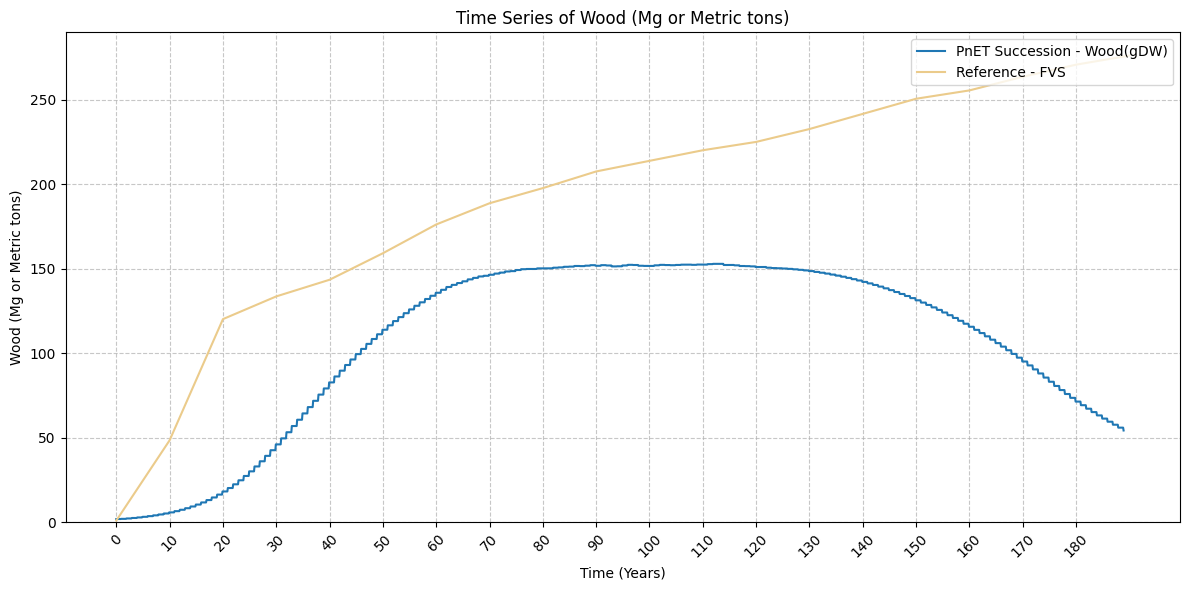

In [9]:
# Ploting the outputs from PnET and FVS together
# We re-format the time entries of the FVS dictionnary so that years are expressed in absoluted (from 0 to 120)
initialKeys = list(balsamFir_HighSiteIndex.keys())
# print(initialKeys)
if initialKeys[0] != 0:
    for key in initialKeys:
        balsamFir_HighSiteIndex[key - 2023] = balsamFir_HighSiteIndex[key]
        del balsamFir_HighSiteIndex[key]

plot_TimeSeries_CSV_PnETSitesOutputs(list(result_sitesCSV.values())[0],
                                     referenceDict = {"Wood(gDW)":{"Time":list(balsamFir_HighSiteIndex.keys()), "Values":list(balsamFir_HighSiteIndex.values())}},
                                     columnToPlotSelector = ["Wood(gDW)"],
                                     trueTime = False,
                                     realBiomass = True,
                                     cellLength = int(PnETGitHub_OneCellSim["scenario.txt"]["CellLength"]))